# Introduction to QAMpy 

Find it at: https://github.com/ChalmersPhotonicsLab/QAMpy

## A simple QPSK simulation

Here we go through how to construct a basic "simulation" for QPSK equalisation. QAMpy aims to have all the relevant building blocks ready for you. 

## The QAMpy API

QAMpy provides two sets of APIs:
* The basic API
  
This works with signal objects (a numpy array subclass). Generally it should do all the right things for you and makes a lot of the repetitive tasks very easy. Importantly we will strife to keep this stable so that code written for older versions should still work with newer versions.
* The core or advanced API

The core or advanced API is where all the actual processing code sits. One of the important things to remember when using is that many of the core API functions do not preserve signalobject class, but instead return numpy arrays, so you will need to keep track of this. 

It should in general be always possible to use the basic API for your processing

## We use the basic API 

## Bokeh is great for plotting
  * significantly faster when using the webgl backend

In [1]:
#%pylab inline
from qampy import signals, impairments, equalisation, phaserec, helpers
import numpy as np
# here we use bokeh for plotting as it is much faster
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
import warnings
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

Lets start by generating a dual polarization QPSK signal, with gray coded bits, a symbol rate of 25 Gbaud $2^{16}$ symbols

In [2]:
sig = signals.SignalQAMGrayCoded(4, 2**16, nmodes=2, fb=25e9)

### The signals module is the core of the QAMPy API, which gives us signals to operatate on.

   * you will most likely be using signal objects
   * They are well documented and are easily subclassable to create your own custom objects

Have a look at the help for the SignalQAMGrayCoded object from above

In [3]:
help(sig)

Help on SignalQAMGrayCoded in module qampy.signals object:

class SignalQAMGrayCoded(SignalBase)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtyp

## A quick convenience function for plotting constellation diagrams

In [4]:
def plot_constellation(E):
    fig = figure(title="QPSK signal constellation", output_backend="webgl")
    fig.scatter(E[0].real, E[0].imag, color='red', alpha=0.3, legend="X")
    fig.scatter(E[1].real, E[1].imag, color='blue', alpha=0.3, legend="Y")
    fig.xaxis[0].axis_label = "In-Phase"
    fig.yaxis[0].axis_label = "Quadrature"
    show(fig)

In [15]:
def plot_constellation(E):
    plt.plot(E[0].real, E[0].imag, '.', label="X")
    plt.plot(E[1].real, E[1].imag, '.', label="Y")
    plt.legend()
    plt.show()

## Let's have a look at our signal

In [5]:
plot_constellation(sig)

## This is kinda boring, lets change the SNR of the signal to 15dB.

In [17]:
signoise = impairments.change_snr(sig, 15)

### What does it look now?

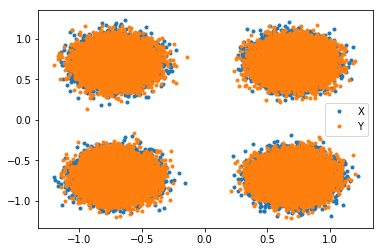

In [18]:
plot_constellation(signoise)

### At this SNR we should not have any errors but lets check
#### See how easy it is to check symbol error rate or bit rate

In [19]:
signoise.cal_ser()

array([0., 0.])

## Generally we would want to oversample our signal... and do some pulseshaping

### Here we resample to 50 GHz and shape with a rrcos filter with $\beta=0.1$

In [20]:
signoise = signoise.resample(signoise.fb*2, beta=0.1, renormalise=True)

### We can easily check sampling rate or symbol rate

In [21]:
signoise.fs

50000000000.0

### plot the constellation again

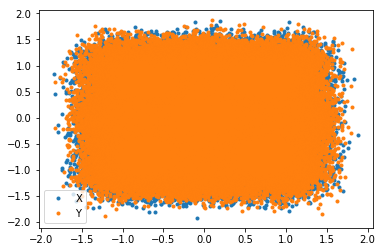

In [22]:
plot_constellation(signoise)

As expected this looks like a mess now, but we are oversampling. 
### Numpy fancy indexing  still works.

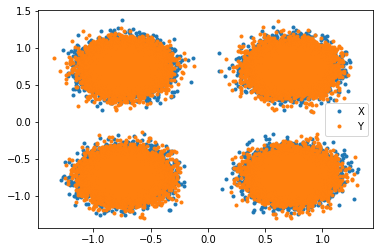

In [23]:
plot_constellation(signoise[:,::2])

## To make a realistic signal 
### Add phase noise of a 100 kHz linewidth laser

In [24]:
signoise = impairments.apply_phase_noise(signoise, 100e3)

## And 40 ps of DGD

In [25]:
signoise= impairments.apply_PMD(signoise, np.pi/5.5, 40e-12)

## This is where we use the equaliser 
  * here we use a CMA equaliser with 17 taps and a stepsize $\mu=2\cdot10^{-3}$

In [26]:
wxy, err = equalisation.equalise_signal(signoise, 2e-3, Ntaps=17 )

## To check convergence have a look at the error 


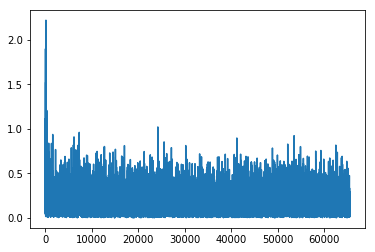

In [30]:
#fig = figure(title="Error")(#, output_backend="webgl")
#fig.line(np.arange(err[0].shape[0]), abs(err[0]), color='red', alpha=1, legend="X")
#fig.xaxis[0].axis_label = "symbol"
#fig.yaxis[0].axis_label = "error"
#show(fig)
plt.plot(abs(err[0]))

## And check the taps 


In [21]:
fig = figure(title="Error", output_backend="webgl")
fig.line(np.arange(wxy[0].shape[1]), wxy[0][0].real, color='red', alpha=1, legend="hxx")
fig.line(np.arange(wxy[0].shape[1]), wxy[0][1].real, color='blue', alpha=1, legend="hxy")
fig.xaxis[0].axis_label = "tap"
fig.yaxis[0].axis_label = "weight"
show(fig)

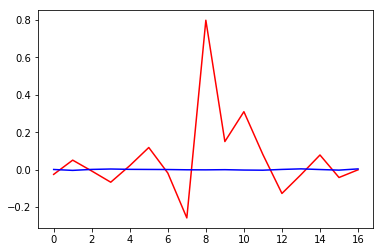

In [31]:
plt.plot(wxy[0][0].real, 'r', label="hxx")
plt.plot(wxy[0][1].real, 'b', label="hxy")
plt.show()

## Equalise the signal
   * by default the filter taps are not applied to the signal
   * do that manually and check the contstellation

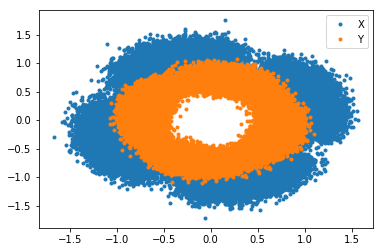

In [32]:
sig_out = equalisation.apply_filter(signoise, wxy)
plot_constellation(sig_out)

## Phase noise

   * The signal still has phase noise
   * For QPSK we can easily do this using the viterbiviterbi algorithm

In [33]:
sig_out, ph = phaserec.viterbiviterbi(sig_out, 11)

Note that we generally need to get rid of the signal edges and we should also renormalise

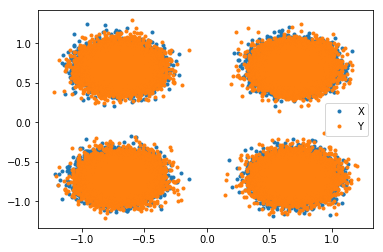

In [34]:
sig_out = helpers.dump_edges(sig_out, 20)
sig_out = helpers.normalise_and_center(sig_out)
plot_constellation(sig_out)

# Signal quality metrics build in
   
   * Symbol error rate (SER)
   * Bit Error Rate (BER)
   * Error Vector Magnitude (EVM), both blind and with known symbols
   * Generalised Mutual Information (GMI)

### Print SER and BER

In [35]:
ser = sig_out.cal_ser()
ber = sig_out.cal_ber()
print("SER_x = %.2f, SER_y= %.2f"%(ser[0], ser[1]))
print("BER_x = %.2f, BER_y = %.2f"%(ber[0], ber[1]))

SER_x = 0.00, SER_y= 0.00
BER_x = 0.00, BER_y = 0.00


### What about GMI and EVM

In [36]:
print(sig_out.cal_gmi())
print(sig_out.cal_evm())

(array([2., 2.]), array([[1., 1.],
       [1., 1.]]))
[0.17596218 0.18078263]


## Equaliser Methods
QAMpy contains several equaliser methods. 
* Two "CMA-type" methods
    * CMA
    * Modified CMA (MCMA) - often better
* RDE type algorithms
* several Decision Directed LMS algorithms

See the equalisation module documentation for details

In [37]:
wxy2, err2 = equalisation.equalise_signal(signoise, 1e-3, Ntaps=21, method="mcma")

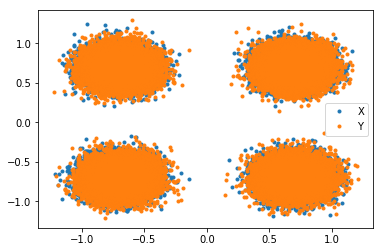

SER =  [0. 0.]
BER =  [0. 0.]


In [38]:
sig_out3 = equalisation.apply_filter(signoise, wxy)
sig_out3, ph = phaserec.viterbiviterbi(sig_out3, 11)
sig_out3 = helpers.normalise_and_center(sig_out3)
sig_out3 = helpers.dump_edges(sig_out3, 10)
plot_constellation(sig_out3)
print("SER = ",sig_out3.cal_ser())
print("BER = ", sig_out3.cal_ber())

## Speed

QAMpy is optimized for speed. It was important for us that you can do adjustments in the lab and look at your constellations "live". 

All the time critical functions are implemented using "cython" and run essentially at C-speed with multi-threading support and a fallback option using numba. We also have some initial GPU processing support, but this is still work in progress (In the future you should be able to select backends quite easily). 
Let's measure the speed this out:

In [39]:
%%timeit 
sig = signals.SignalQAMGrayCoded(4, 10**5, fb=25e9, nmodes=2)
sig = sig.resample(sig.fb*2, beta=0.1, renormalise=True)
sig = impairments.apply_phase_noise(sig, 100e3)
sig = impairments.apply_PMD(sig, np.pi/5.6, 60e-12)
sig = impairments.change_snr(sig, 15)
wxy, err = equalisation.equalise_signal(sig, 1e-3, Ntaps=21, method="mcma")
sig_out3 = equalisation.apply_filter(sig, wxy)
sig_out3, ph = phaserec.viterbiviterbi(sig_out3, 11)
sig_out3 = helpers.normalise_and_center(sig_out3)
sig_out3 = helpers.dump_edges(sig_out3, 10)


440 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The equaliser is actually much faster than a lot of the other things

In [40]:
%%timeit
equalisation.equalise_signal(sig, 1e-3, Ntaps=21, method="mcma")

26.3 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# This is even more impressive if you put it in a loop

In [41]:
# setup some data first because we want to demo the time of the equaliser
sigs = []
for i in range(5):
    s = signals.SignalQAMGrayCoded(4, 10**5, nmodes=2, fb=40e9)
    s = s.resample(2*s.fb, beta=0.1, renormalise=True)
    s = impairments.change_snr(s, 13)
    s = impairments.apply_PMD(s, np.pi/5.5, 50e-12)
    sigs.append(s)
#fig = figure(title="QPSK signal constellation", output_backend="webgl")
#Xp = fig.scatter(x=s[0].real, y=s[0].imag,  color='blue', alpha=0.3)
#Yp = fig.scatter(x=s[1].real, y=s[1].imag,  color='red', alpha=0.3)
handle=show(fig, notebook_handle=True)

for i in range(50):
    wxy, err = equalisation.equalise_signal(sigs[i%5], 2e-3, Ntaps=17, method="mcma", adaptive_stepsize=True)
    sout = equalisation.apply_filter(sigs[i%5], wxy)
    sout = helpers.normalise_and_center(sout)
    # note plotting is a significant bottleneck if we plot all points!
    Xp.data_source.data["x"] = sout[0][::10].real
    Xp.data_source.data["y"] = sout[0][::10].imag
    Yp.data_source.data["x"] = sout[1][::10].real
    Yp.data_source.data["y"] = sout[1][::10].imag
    #push_notebook()

TypeError: __init__() got an unexpected keyword argument 'title'

## How can we calculate the SER without the symbols?


In [42]:
sig

SignalQAMGrayCoded([[ 0.70710678-0.70710678j, -0.70710678+0.70710678j,
                     -0.70710678-0.70710678j, ...,
                      0.70710678+0.70710678j,  0.70710678-0.70710678j,
                      0.70710678+0.70710678j],
                    [-0.70710678-0.70710678j,  0.70710678+0.70710678j,
                     -0.70710678+0.70710678j, ...,
                      0.70710678+0.70710678j, -0.70710678+0.70710678j,
                      0.70710678+0.70710678j]])

## What are these objects?

  * Signals are numpy array subclasses

In [43]:
isinstance(sig, np.ndarray)

True

  * a lot of nice build in functionality

In [44]:
print(sig.cal_ser())
print(sig.cal_gmi())
print(sig.fb)
print(sig.fs)

[0. 0.]
(array([2., 2.]), array([[1., 1.],
       [1., 1.]]))
25000000000.0
25000000000.0


  * all (almost) all array functions work

In [45]:
s2= sig*2+np.ones(sig.shape)
print(type(s2))

<class 'qampy.signals.SignalQAMGrayCoded'>


   * they remember their original symbols

In [46]:
s2 = sig.resample(2*sig.fb, beta=0.2)
np.all(s2.symbols ==  sig.symbols)

SignalQAMGrayCoded(True)

and much more (see the documentation)

## Saving signal objects to file

You can use `np.save` and `np.savez` for saving files. However, those two functions will save only the array portion of the signal.

In [47]:
np.save('test.npy', sig)
o = np.load('test.npy')
print(type(o))

<class 'numpy.ndarray'>


### Use pickle for saving signal files

Signal objects are pickle compatible however, so you can use pickle to save and preserve all attributes. Note: if you are on python 2.7 you should probably use `cPickle` instead as it is much faster (this is not necessary in Python 3). 

In [48]:
import pickle
fp = open('test.pic', 'wb') # The 'wb' is important because we want to save bytes
pickle.dump(sig, fp, protocol=pickle.HIGHEST_PROTOCOL) # generally using HIGHEST_PROTOCOL will give the fastest speed if that is critical
fp.close()
fp = open('test.pic', 'rb')
sig_l = pickle.load(fp)
print(type(sig_l))
fp.close()

<class 'qampy.signals.SignalQAMGrayCoded'>
